#Постановка
Посчитать количество точек притяжения категории «Продуктовые магазины» в Прикубанском районе Краснодара. Данные по этим точкам, которые по умолчанию есть в OSM, не подойдут - их надо обогатить из источника более валидных данных.

Результат - шейп-файл с отмеченными точками на карте, который можно открыть в qgis + короткое описание что делали.

#Решение
Для начала необходимо выбрать ресурс, с которого можно забрать данные. Я выделил три:



1.   Яндекс.Карты
2.   2ГИС
3.   OSM


Минусом Яндекс.Карт является ограниченное кол-во запросов через API. Для 2ГИС необходимо получать верификацию для использования API (запрос отправил, но так и не получил ответа). Поэтому оптимальным решением является отбор координат и адресов точек из OSM, а потом их обогащение через сторонние сервисы (например, Яндекс.Карты)

Сам ресурс OSM был мне не знаком, поэтому пришлось прочитать документацию для составления правильного запроса. Саму границу области поиска. Я выделил три способа:



1.   Задать прямоугольник по двум координатам. Но такой способ будет очень не точным с большой погрешностью
2.   С помощью (osmconver) можно создать полигон обрезки из ломанных линий. Это будет выглядеть как набор пар координат. Данный метод является не оптимальным по времени для данной задачи, но самым точным
3.   Задать "Прикубанский округ" в переменную по уже существующей разметке. В данной разметке есть погрешности, но она намного лучше приближает область округа, чем прямоугольник

Делается это следующей строкой: 

```
area[name="Прикубанский округ"][admin_level=9]
```
Далее необходимо выяснить, как отобрать продуктовые магазины. Это тоже можно сделать с помощью комбинации тегов. Более детально можно поситать про теги здесь:

[Библиотека тегов](https://taginfo.openstreetmap.org/)

Для данной задачи были выбраны следующие теги (одного описательного я не нашел среди класса **amenity**):

**shop**=convenience — небольшой местный магазин, в котором продаются различные товары повседневного спроса, такие как продукты питания и средства гигиены

**shop**=supermarket — аналогичные магазины которые продают целый ряд товаров, но которые являются большими. Предлагаемое разграничение: достаточно большие для использования тележек. Пожалуйста, обратите внимание, что многие небольшие магазины называют себя супермаркетами. Пожалуйста, выберите тег в зависимости от размера магазина, а не от его названия.

**shop**=general — очень похожий тип магазина, но, как правило, с еще более широким кругом товаров, включая инструменты, строительные материалы. Продает всё, потому что это единственный магазин в округе (например магазины в деревнях).

**shop**=greengrocer — очень похожий магазин (и аналогичных размеров), но сосредоточен на фруктах и овощах.

**shop**=kiosk — очень маленький магазин (киоск, ларёк) продающий сигареты, газеты, сладости, легкие закуски и прочую мелочь

Теперь посчитаем кол-во таких магазинов:

In [26]:
pip install overpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.7 MB/s 
  Created wheel for overpy: filename=overpy-0.6-py3-none-any.whl size=14106 sha256=bd4be6f443a4d19291b9977f78ded3b35511b05a6c09daf6bdaa72e15bab26b1
  Stored in directory: /root/.cache/pip/wheels/1a/d3/0e/090c6914956cc37881fc914101d2a952c0da8e66fc86dc6a31
Successfully built overpy


In [27]:
pip install dadata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 68 kB 5.7 MB/s 
     |████████████████████████████████| 80 kB 9.7 MB/s 
     |████████████████████████████████| 54 kB 4.0 MB/s 


In [190]:
pip install fiona

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 5.1 MB/s 


In [194]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 47.4 MB/s 


In [202]:
import overpy
import requests
from pprint import pprint
import pandas as pd
import numpy as np
from time import sleep
import fiona
import geopandas as gpd
from shapely.geometry import Point
from google.colab import files

In [30]:
api = overpy.Overpass()
Data_convenience = api.query("""
area[name="Прикубанский округ"][admin_level=9];
(
  node["shop"="convenience"](area);
  way["shop"="convenience"](area);
  relation["shop"="convenience"](area);
);
out body;
>;
out skel qt;
""")

Data_supermarket = api.query("""
area[name="Прикубанский округ"][admin_level=9];
(
  node["shop"="supermarket"](area);
  way["shop"="supermarket"](area);
  relation["shop"="supermarket"](area);
);
out body;
>;
out skel qt;
""")

Data_general = api.query("""
area[name="Прикубанский округ"][admin_level=9];
(
  node["shop"="general"](area);
  way["shop"="general"](area);
  relation["shop"="general"](area);
);
out body;
>;
out skel qt;
""")

Data_greengrocer = api.query("""
area[name="Прикубанский округ"][admin_level=9];
(
  node["shop"="greengrocer"](area);
  way["shop"="greengrocer"](area);
  relation["shop"="greengrocer"](area);
);
out body;
>;
out skel qt;
""")

Data_kiosk = api.query("""
area[name="Прикубанский округ"][admin_level=9];
(
  node["kiosk"="kiosk"](area);
  way["kiosk"="kiosk"](area);
  relation["shop"="kiosk"](area);
);
out body;
>;
out skel qt;
""")


In [31]:

coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in Data_convenience.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in Data_convenience.ways]
coords += [(float(rel.center_lon), float(rel.center_lat))
           for rel in Data_convenience.relations]

coords += [(float(node.lon), float(node.lat)) 
           for node in Data_supermarket.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in Data_supermarket.ways]
coords += [(float(rel.center_lon), float(rel.center_lat))
           for rel in Data_supermarket.relations]

coords += [(float(node.lon), float(node.lat)) 
           for node in Data_general.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in Data_general.ways]
coords += [(float(rel.center_lon), float(rel.center_lat))
           for rel in Data_general.relations]

coords += [(float(node.lon), float(node.lat)) 
           for node in Data_greengrocer.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in Data_greengrocer.ways]
coords += [(float(rel.center_lon), float(rel.center_lat))
           for rel in Data_greengrocer.relations]

coords += [(float(node.lon), float(node.lat)) 
           for node in Data_kiosk.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in Data_kiosk.ways]
coords += [(float(rel.center_lon), float(rel.center_lat))
           for rel in Data_kiosk.relations]                                            
#координаты записаны наоборот

print(len(Data_convenience.nodes) + len(Data_supermarket.nodes) + len(Data_general.nodes) + len(Data_greengrocer.nodes) + len(Data_kiosk.nodes)) #получаем общее количество узлов

428


Получили **428** объектов

Далее предлагаю восстановить корректные координаты точек по их адресу через Яндекс.Карты. Для начала получим адрес по координатам из OSM: 

In [80]:
df = pd.DataFrame(coords)
df.columns = ['lon', 'lat']

for index,row in df.iterrows():
  lon = df['lon'].iloc[index]
  lat = df['lat'].iloc[index]
  url=f'https://nominatim.openstreetmap.org/search.php?q={lat}+{lon}+&format=jsonv2'
  point  = requests.get(url).json()
  point = point[0]
  df['adress'].iloc[index] = point['display_name']

df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,lon,lat,adress
0,38.998903,45.149798,"Агрокомплекс Выселковский, 1/1, Ейское шоссе, ..."
1,38.979628,45.073394,"Магнат, проезд Репина, Прикубанский округ, Кра..."
2,38.980844,45.073823,"22, проезд Репина, Прикубанский округ, Краснод..."
3,38.982050,45.073874,"20, проезд Репина, Прикубанский округ, Краснод..."
4,38.984145,45.108671,"Домашняя кухня, улица им. Соколова М.Е., микро..."
...,...,...,...
423,39.011233,45.088930,"Добро кубани, 25/1, улица Дунаевского, Микрора..."
424,39.001620,45.082000,"Графиня вишенька, Московская улица, Прикубанск..."
425,39.022008,45.055825,"Овощи Фрукты, 77/1, улица 40 лет Победы, Прику..."
426,39.008842,45.087073,"22, улица имени Рахманинова С.В., Микрорайон и..."


Приступим к обратному геокодированию через Яндекс. Завёл себе два ключа для API Яндекс.Карт:


*   Геокодер: 4ad40cbd-83bc-4e15-935a-93ed4205a386
*   Поиск по организации: e6ce00d5-f47e-4cf8-b5a1-fa052b4cd913

Пропишем функцию для обращения по API и парсингу ответа:

In [81]:
def fetch_coordinates(apikey, address):
    base_url = "https://geocode-maps.yandex.ru/1.x"
    response = requests.get(base_url, params={
        "geocode": address,
        "apikey": apikey,
        "format": "json",
    })
    response.raise_for_status()
    found_places = response.json()['response']['GeoObjectCollection']['featureMember']

    if not found_places:
        return None

    most_relevant = found_places[0]
    lon, lat = most_relevant['GeoObject']['Point']['pos'].split(" ")
    return lon, lat

Ответ приходит следующим образом:

In [141]:
apikey = '4ad40cbd-83bc-4e15-935a-93ed4205a386'  # ваш ключ

coords = fetch_coordinates(apikey, "Продукты, улица 1 Мая, Прикубанский округ, Краснодар, городской округ Краснодар, Краснодарский край, Южный федеральный округ, 350901, Россия")
print(coords)  

# было 39.1046781	45.0885102
# стало ('39.104724', '45.088573')

('39.020202', '45.084081')


Теперь обогатим наш Датафрейм координатами из Яндекса:

In [188]:
df = df.rename(columns={'lon' : 'lon_osm','lat' : 'lat_osm'}) 

apikey = '4ad40cbd-83bc-4e15-935a-93ed4205a386' 

time_to_sleep_when_captcha = 1 

lon_ya = []
lat_ya = []
for index, row in df[['adress','lon_osm','lat_osm']].iterrows(): 
    try: 
        coords = fetch_coordinates(apikey, row['adress']) 
        lon_ya.append(float(coords[0]))
        lat_ya.append(float(coords[1]))
    except: 
        sleep(time_to_sleep_when_captcha) 
        time_to_sleep_when_captcha += 0
        lon_ya.append(float(row['lon_osm']))
        lat_ya.append(float(row['lat_osm']))

df["lon_ya"] = lon_ya
df["lat_ya"] = lat_ya
df = df[['adress','lon_ya','lat_ya']]
df

,adress,lon_ya,lat_ya
0,"Агрокомплекс Выселковский, 1/1, Ейское шоссе, ...",38.998903,45.149798
1,"Магнат, проезд Репина, Прикубанский округ, Кра...",38.979706,45.074349
2,"22, проезд Репина, Прикубанский округ, Краснод...",38.980209,45.074082
3,"20, проезд Репина, Прикубанский округ, Краснод...",38.981601,45.074069
4,"Домашняя кухня, улица им. Соколова М.Е., микро...",38.986533,45.115332
...,...,...,...
423,"Добро кубани, 25/1, улица Дунаевского, Микрора...",39.011233,45.088930
424,"Графиня вишенька, Московская улица, Прикубанск...",39.000906,45.073025
425,"Овощи Фрукты, 77/1, улица 40 лет Победы, Прику...",39.022008,45.055825
426,"22, улица имени Рахманинова С.В., Микрорайон и...",39.004266,45.086830


Теперь всё готово. Осталось только преобразовать результат в shape-файл

In [204]:
geometry = [Point(xy) for xy in zip(df['lon_ya'], df['lat_ya'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.to_file(filename='krasnodar_shop.shp', encoding='cp1251', driver='ESRI Shapefile')

#Приложение
Данное задание сделано в тестовом режиме. Для полноценного релиза в промышленную среду необходимы проработать следующие вопросы:



1.   Корректная обрезка области (полигона). 

Погрешность достаточно небольшая, если работать с полигона OSM. Открытые источники сообщают, что она составляет около 2-3%
2.   Собственная библиотека тегов в OSM

Чтобы правильно класифицировать объекты нужна хорошая библиотека. Да, теги достаточно хорошо работают и модерируются в текущей. Но есть много недостающий объектов (например, мосты. Чтобы работать с ними, необходимо будет пересечь два слоя: дороги и реки/моря/озера/океаны; и посмотреть на их точки пересечения) и объекты могут достаточно активно менять свою классификацию (например, в моём случае спустя день после написания кода добавилось 2 продуктовых магазина) общаясь напрямую через форумы [Форум OSM](https://forum.openstreetmap.org/)

3.    Доступные API

Стоит отдельно отметить, что разные ресурсы имеют разную точность. Проделав ресерч по данному вопросу я наткнулся на исследование, которое четко показывает на ограниченной выборке, как отличаются данные с разных ресурсов ([Прямое и обратное геокодирование – тестирование популярных решений
](https://habr.com/ru/amp/post/505500/))
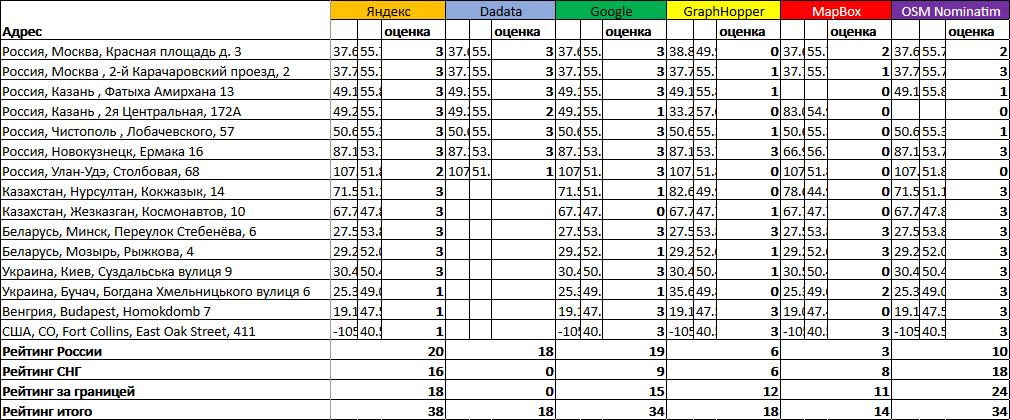

4.    Улучшенное геокодирование построек сельской местности

Стоит также отметить, что при прямом и обратном кодировании построек сельской местности возникают проблемы. Не на каждом ресурсе можно найти однозначное соответствие, так как адрес у таких объектов может быть не полный. В таком случае необходимо лезть за более детальными мета-данными в OSM и проводить детальный парсинг (в данной работе не проводился)
